In [3]:
import pandas as pd

df = pd.read_csv("/Users/dhrithijuvva/Desktop/Women_ML/extracted_audio_features.csv")
print(df.columns)

Index(['MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8',
       'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'MFCC13', 'Label', 'Set'],
      dtype='object')


In [4]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/Users/dhrithijuvva/Desktop/Women_ML/extracted_audio_features.csv")

# Target column
target_col = "Label"

# Equal-width binning function
def equal_width_binning(series, bins=4):
    return pd.cut(series, bins=bins, labels=False)

# Entropy function
def entropy(column):
    values, counts = np.unique(column, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

# If target is continuous → bin it
if df[target_col].dtype != "object":
    df[target_col] = equal_width_binning(df[target_col], bins=4)

print("Entropy of target:", entropy(df[target_col]))


Entropy of target: 1.5849474223734454


In [5]:
def gini_index(column):
    values, counts = np.unique(column, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

print("Gini Index of target:", gini_index(df[target_col]))


Gini Index of target: 0.6666596915646801


In [6]:
def information_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values, counts = np.unique(df[feature], return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset = df[df[feature] == v][target]
        weighted_entropy += (c/len(df)) * entropy(subset)

    return total_entropy - weighted_entropy

# Apply on MFCC features
features = [col for col in df.columns if col.startswith("MFCC")]
best_feature = max(features, key=lambda f: information_gain(df, f, target_col))
print("Best feature (root node):", best_feature)


Best feature (root node): MFCC5


In [7]:
def binning(series, bins=4, method="width"):
    if method == "width":
        return pd.cut(series, bins=bins, labels=False)
    elif method == "frequency":
        return pd.qcut(series, q=bins, labels=False, duplicates="drop")
    else:
        raise ValueError("Method must be 'width' or 'frequency'")

# Example: bin MFCC1 into 3 bins using frequency binning
df["MFCC1_binned"] = binning(df["MFCC1"], bins=3, method="frequency")
print(df[["MFCC1", "MFCC1_binned"]].head())


       MFCC1  MFCC1_binned
0  719.38306             1
1  741.59590             1
2  760.04610             1
3  765.75780             1
4  888.53595             2


In [9]:
# First bin all MFCCs into categories (say 3 bins each)
for col in [c for c in df.columns if c.startswith("MFCC")]:
    df[col] = pd.qcut(df[col], q=3, labels=False, duplicates="drop")

class DecisionTree:
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def build_tree(self, data=None, depth=0):
        if data is None:
            data = self.df

        # If all labels are same → return that label
        if len(np.unique(data[self.target])) == 1:
            return np.unique(data[self.target])[0]

        # If no features left → return majority class
        features = [col for col in data.columns if col != self.target and col.startswith("MFCC")]
        if len(features) == 0:
            return data[self.target].mode()[0]

        # Pick best feature
        best_feature = max(features, key=lambda f: information_gain(data, f, self.target))

        tree = {best_feature: {}}
        for value in np.unique(data[best_feature]):
            sub_data = data[data[best_feature] == value].drop(columns=[best_feature])
            
            # If sub_data becomes empty → return majority
            if sub_data.shape[0] == 0:
                tree[best_feature][value] = data[self.target].mode()[0]
            else:
                tree[best_feature][value] = self.build_tree(sub_data, depth+1)

        return tree

# Example usage
dt = DecisionTree(df, target_col)
my_tree = dt.build_tree()
print("Constructed Tree:", my_tree)


Constructed Tree: {'MFCC3': {np.int64(0): {'MFCC13': {np.int64(0): {'MFCC4': {np.int64(0): {'MFCC10': {np.int64(0): {'MFCC12': {np.int64(0): {'MFCC6': {np.int64(0): {'MFCC7': {np.int64(0): {'MFCC11': {np.int64(0): {'MFCC2': {np.int64(0): 'Child', np.int64(1): {'MFCC1': {np.int64(1): {'MFCC9': {np.int64(0): 'Women', np.int64(1): 'Child'}}, np.int64(2): 'Child'}}, np.int64(2): {'MFCC1': {np.int64(2): {'MFCC5': {np.int64(0): {'MFCC8': {np.int64(0): {'MFCC9': {np.int64(0): {'MFCC1_binned': {np.int64(1): 'Child'}}}}}}}}}}}}, np.int64(1): {'MFCC8': {np.int64(0): 'Women', np.int64(1): 'Child'}}, np.int64(2): 'Women'}}, np.int64(1): 'Child', np.int64(2): {'MFCC8': {np.int64(0): 'Child', np.int64(1): 'Women'}}}}, np.int64(1): {'MFCC11': {np.int64(0): {'MFCC5': {np.int64(0): 'Child', np.int64(1): {'MFCC1': {np.int64(1): 'Child', np.int64(2): 'Women'}}}}, np.int64(1): {'MFCC1': {np.int64(1): 'Child', np.int64(2): 'Women'}}, np.int64(2): 'Child'}}, np.int64(2): {'MFCC5': {np.int64(0): 'Child', np.

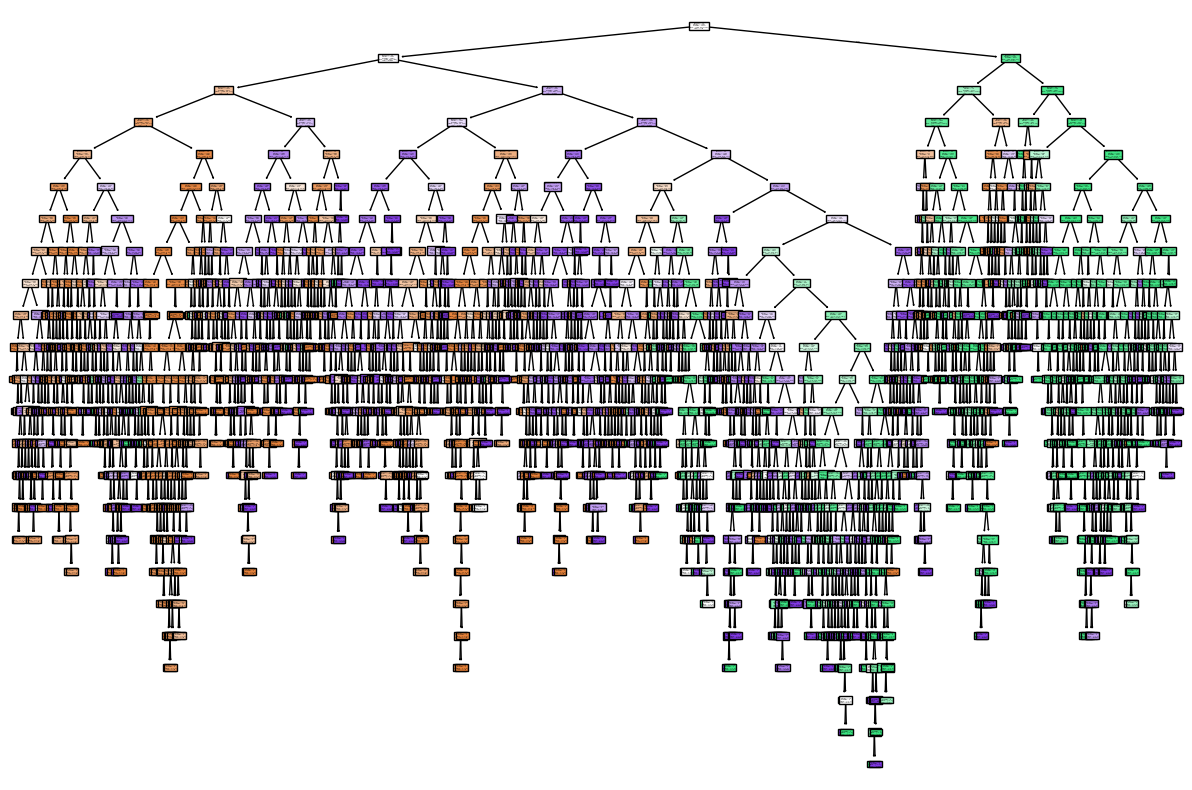

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

X = df[[col for col in df.columns if col.startswith("MFCC")]]
y = df[target_col]

clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X, y)

plt.figure(figsize=(15,10))
plot_tree(clf, feature_names=X.columns, class_names=[str(c) for c in np.unique(y)], filled=True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

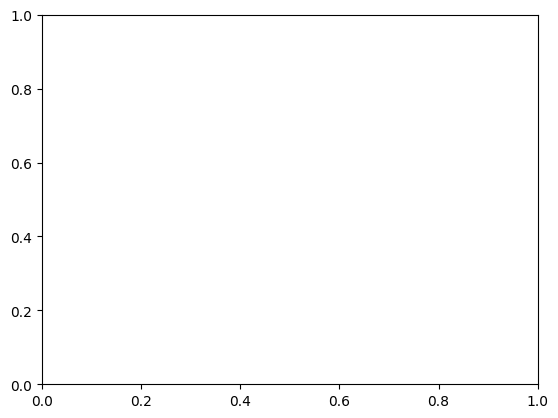

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Pick two MFCC features
feat1, feat2 = "MFCC1", "MFCC2"
X2 = df[[feat1, feat2]]
y = df[target_col]

clf2 = DecisionTreeClassifier(criterion="entropy")
clf2.fit(X2, y)

# Mesh grid
x_min, x_max = X2[feat1].min()-1, X2[feat1].max()+1
y_min, y_max = X2[feat2].min()-1, X2[feat2].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2[feat1], X2[feat2], c=y, edgecolor="k")
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title("Decision Boundary (MFCC1 vs MFCC2)")
plt.show()
